In [40]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [41]:
# Load the data
df = pd.read_csv('JaipurFinalCleanData.csv', index_col='date', parse_dates=True).dropna()
df.head()

,meantempm,maxtempm,mintempm,meantempm_1,meantempm_2,meantempm_3,meandewptm_1,meandewptm_2,meandewptm_3,meanpressurem_1,...,mindewptm_3,maxpressurem_1,maxpressurem_2,maxpressurem_3,minpressurem_1,minpressurem_2,minpressurem_3,precipm_1,precipm_2,precipm_3
date,,,,,,,,,,,,,,,,,,,,,
2016-05-04,34,41,27,35.0,36.0,34.0,6.0,4.0,-1.0,1006.00,...,-10.0,1009.0,1008.0,1009.0,1000.0,1001.0,999.0,0.0,0.0,0.0
2016-05-05,31,38,24,34.0,35.0,36.0,7.0,6.0,4.0,1005.65,...,-2.0,1008.0,1009.0,1008.0,1001.0,1000.0,1001.0,0.0,0.0,0.0
2016-05-06,28,34,21,31.0,34.0,35.0,11.0,7.0,6.0,1007.94,...,-2.0,1011.0,1008.0,1009.0,1003.0,1001.0,1000.0,5.0,0.0,0.0
2016-05-07,30,38,23,28.0,31.0,34.0,13.0,11.0,7.0,1008.39,...,0.0,1011.0,1011.0,1008.0,1004.0,1003.0,1001.0,0.0,5.0,0.0
2016-05-08,34,41,26,30.0,28.0,31.0,10.0,13.0,11.0,1007.62,...,6.0,1010.0,1011.0,1011.0,1002.0,1004.0,1003.0,0.0,0.0,5.0


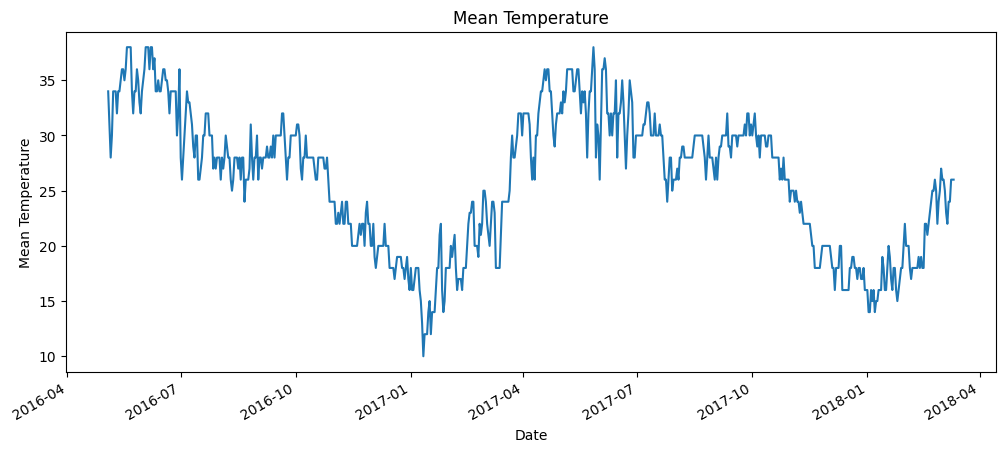

In [42]:
df['meantempm'].plot(figsize=(12, 5))
plt.title('Mean Temperature')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.show()

In [43]:
# Preprocess the data
data = df['meantempm'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [44]:
# Define sequence length
sequence_length = 30

In [45]:
# Prepare data for training
X, y = [], []
for i in range(len(data_scaled) - sequence_length):
    X.append(data_scaled[i:i+sequence_length, 0])
    y.append(data_scaled[i+sequence_length, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  #(number of samples, sequence length=30, number of features=1)
X.shape

(646, 30, 1)

In [46]:
# Split the dataset into training and testing sets
split = int(0.8 * len(data_scaled))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [47]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=32, input_shape=(X.shape[1], X.shape[2]), activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1)) 
model.compile(loss='mean_squared_error', optimizer='adam')

In [48]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=30, validation_split=0.1, verbose=1)

# Make predictions
test_predictions_scaled = model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions_scaled).flatten()

Epoch 1/50


17/17 [==============================] - 1s 17ms/step - loss: 0.4148 - val_loss: 0.2983
Epoch 2/50
17/17 [==============================] - 0s 6ms/step - loss: 0.3755 - val_loss: 0.2364
Epoch 3/50
17/17 [==============================] - 0s 6ms/step - loss: 0.2555 - val_loss: 0.0682
Epoch 4/50
17/17 [==============================] - 0s 6ms/step - loss: 0.0420 - val_loss: 0.0109
Epoch 5/50
17/17 [==============================] - 0s 6ms/step - loss: 0.0174 - val_loss: 0.0070
Epoch 6/50
17/17 [==============================] - 0s 6ms/step - loss: 0.0125 - val_loss: 0.0132
Epoch 7/50
17/17 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0121
Epoch 8/50
17/17 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0082
Epoch 9/50
17/17 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0067
Epoch 10/50
17/17 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0073
Epoch 11/50
17/17 [==========

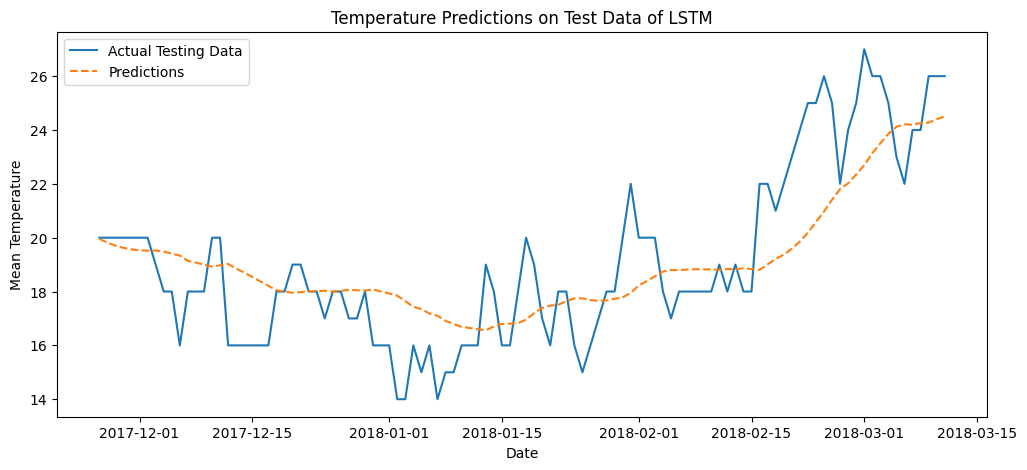

In [49]:
# Plotting predictions vs. actual
plt.figure(figsize=(12, 5))
plt.plot(df.index[split+sequence_length:], df['meantempm'][split+sequence_length:], label='Actual Testing Data')
plt.plot(df.index[split+sequence_length:], test_predictions, label='Predictions', linestyle='dashed')
plt.title('Temperature Predictions on Test Data of LSTM')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.legend()
plt.show()

In [50]:
# Calculating RMSE for test predictions
from sklearn.metrics import mean_squared_error
from math import sqrt

test_actual_temps = df['meantempm'][split + sequence_length:].values
test_mse = mean_squared_error(test_actual_temps, test_predictions)
test_rmse = sqrt(test_mse)

print(f"Root Mean Squared Error (RMSE) on Test Data: {test_rmse}")


Root Mean Squared Error (RMSE) on Test Data: 1.9723246122312266


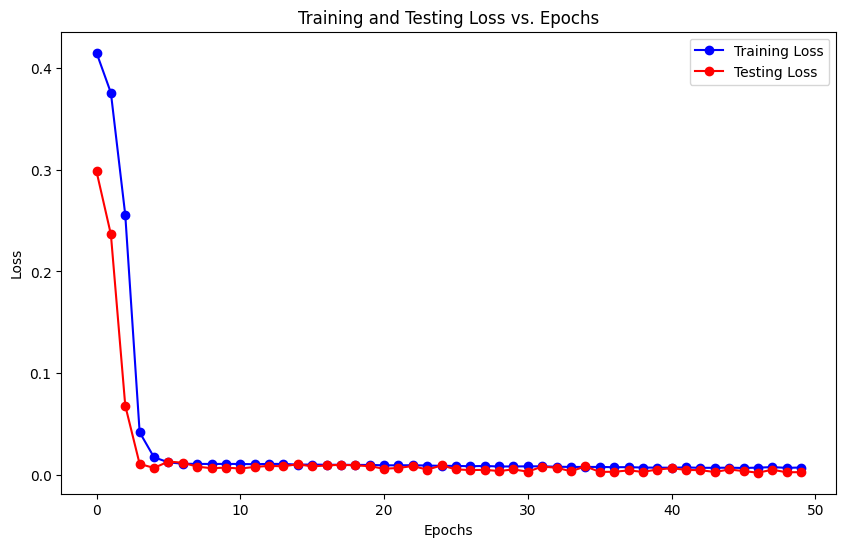

In [51]:
# Plotting Training and Testing Loss vs. Epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], 'bo-', label='Training Loss')
plt.plot(history.history['val_loss'], 'ro-', label='Testing Loss')
plt.title('Training and Testing Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
